<code style="background:none">Author: Iman Irajian</code> $\infty$

<table style="float:left">
    <thead>
        <tr>
            <th colspan=2>Contact</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Email:</td>
            <td><a style="text-decoration:none" href="mailto:iman.irajian@gmail.com?subject=Github machine-learning repository"><code style="color:darkblue; background:none;">iman.irajian@gmail.com</code></a></td>
        </tr>
        <tr>
            <td>LinkedIn:</td>
            <td><a style="text-decoration:none" href="https://www.linkedin.com/in/imanirajian/"><code style="color:darkblue; background:none;">linkedin.com/in/imanirajian</code></a></td>
        </tr>        
    </tbody>
</table>

> **"Happiness is not something you postpone for the future; it is something you design for the present."** -- Jim Rohn

> **"You cannot change your destination overnight, but you can change your direction overnight."** -- Jim Rohn

#### **Model:** Convolutional *AutoEncoder*
+ **Library:** PyTorch
+ **Device:** GPU or CPU
+ **Dependency:** `mnist_helper.py`

#### **Dataset:** *MNIST*

---
---

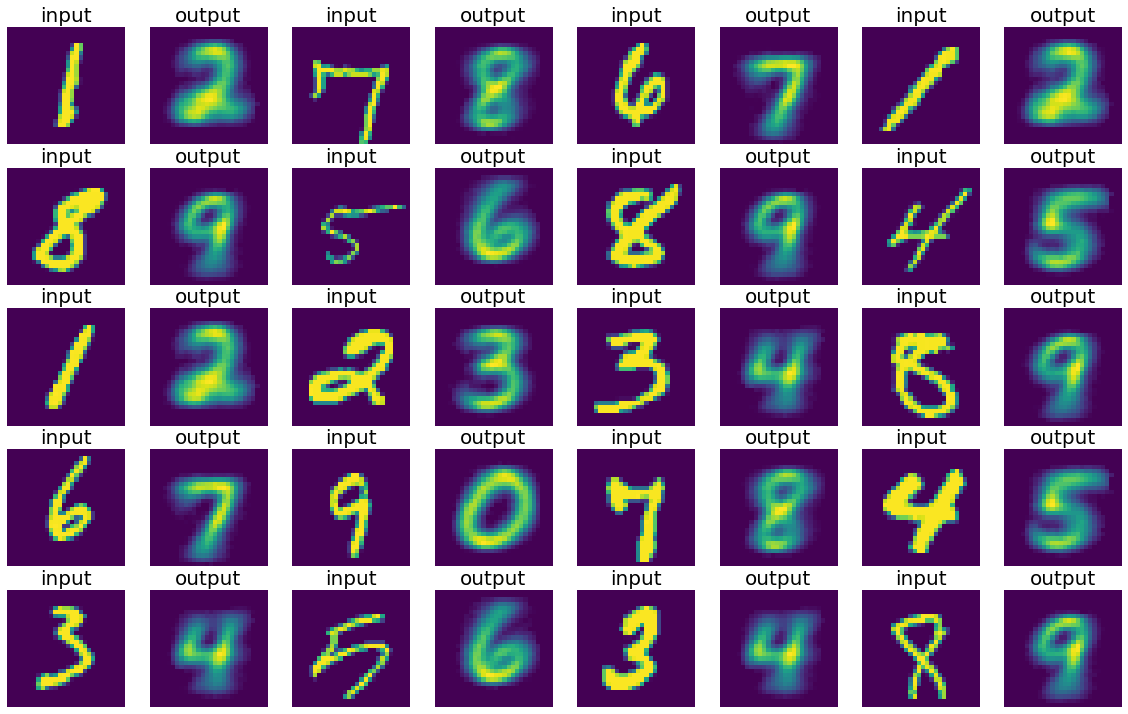

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/ColabNotebooks/Projects/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ColabNotebooks/Projects


In [ ]:
from Helpers.mnist_helper import get_data
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from typing import Tuple

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

In [ ]:
def show_example(target_set_name, idx):    
    plt.subplots(1, 2, figsize=(5.7, 3))
    plt.subplot(1, 2, 1)    
    plt.imshow(eval(f"X_{target_set_name}[idx]"))    
    plt.title(f"X_{target_set_name}[{idx}]")
    plt.subplot(1, 2, 2)
    plt.imshow(eval(f"Y_{target_set_name}[idx]"))    
    plt.title(f"Y_{target_set_name}[{idx}]")
    plt.suptitle(f"Example index {str(idx)} from {target_set_name} set (y_{target_set_name}=" + str(eval(f"y_{target_set_name}[idx]")) + ")", fontweight="bold")
    plt.show()

show_example("train", idx=0)
show_example("train", idx=1)
show_example("test", idx=0)
show_example("val", idx=0)

In [ ]:
print("Shapes:")
print("\ttrain>")
print("\t\tX_train:", X_train.shape)
print("\t\tY_train:", Y_train.shape)
print("\t\ty_train:", y_train.shape)
print("\ttest>")
print("\t\tX_test:", X_test.shape)
print("\t\tY_test:", Y_test.shape)
print("\t\ty_test:", y_test.shape)
print("\tval>")
print("\t\tX_val:", X_val.shape)
print("\t\tY_val:", Y_val.shape)
print("\t\ty_val:", y_val.shape)

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, latent_size):
        super().__init__()
        
        # CONVOLUTIONAL
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        # FLATTEN
        self.flatten = nn.Flatten(start_dim=1)

        # LINEAR
        self.linear = nn.Sequential(
            nn.Linear(3 * 3 * 64, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_size)
        )
        
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x


class Decoder(nn.Module):
    
    def __init__(self, latent_size):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 64),
            nn.ReLU(True)
        )

        # UNFLATTEN
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(64, 3, 3))

        # CONVOLUTIONAL_TRANSPOSE
        self.convtranspose = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.linear(x)
        x = self.unflatten(x)
        x = self.convtranspose(x)
        x = torch.sigmoid(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train_epoch(autoencoder, device, dataloader, loss_fn, optimizer):
    autoencoder.train()
    train_loss = []
    for b, image_batch in enumerate(dataloader):
        image_batch_X = image_batch[0].unsqueeze(1).to(device)
        image_batch_Y = image_batch[1].unsqueeze(1).to(device)
        decoded_data = autoencoder(image_batch_X)
        loss = loss_fn(decoded_data, image_batch_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (b+1)%10==0:
            print(f"\t train loss on {b+1}-th batch: %f" % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

def test_epoch(autoencoder, device, dataloader, loss_fn):
    autoencoder.eval()
    with torch.no_grad(): 
        conc_out = []
        conc_label = []
        for b, image_batch in enumerate(dataloader):
            image_batch_X = image_batch[0].unsqueeze(1).to(device)
            image_batch_Y = image_batch[1].unsqueeze(1).to(device)
            decoded_data = autoencoder(image_batch_X)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch_Y.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def plot_outputs(autoencoder, n=40):
    plt.figure(figsize=(6, 2))
    t_idx = np.random.randint(0, X_test.shape[0], n)

    for i in range(n):
      ax = plt.subplot(int(n/10), 10, i+1)
      img = X_test[t_idx[i]]
      autoencoder.eval()
      with torch.no_grad():
         img = torch.tensor(img.reshape((1, 1, 28, 28))).to(device)
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)        
    plt.suptitle("Random inputs", fontweight="bold")       
    plt.show() 

    plt.figure(figsize=(6, 2))
    for i in range(n):
      ax = plt.subplot(int(n/10), 10, i+1)
      img = X_test[t_idx[i]]
      autoencoder.eval()
      with torch.no_grad():
         img = torch.tensor(img.reshape((1, 1, 28, 28))).to(device)
         rec_img = autoencoder(img)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)        
    plt.suptitle("Outputs", fontweight="bold")      
    plt.show() 

In [ ]:
class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [ ]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)

val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [ ]:
latent_size = 8
lr = 0.001
weight_decay=1e-05

autoencoder = AutoEncoder(latent_size)
params = [{"params": autoencoder.parameters()}]
optim = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
loss_fn = torch.nn.MSELoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")
autoencoder.to(device)

In [ ]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####

num_epochs = 15

loss_data = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   print("---")
   train_loss = train_epoch(autoencoder, device, train_dataloader, loss_fn, optim)
   val_loss = test_epoch(autoencoder, device, val_dataloader, loss_fn)
   print('\n Epoch {}/{} \t train loss {} \t val loss {}\n'.format(epoch + 1, num_epochs, train_loss, val_loss))
   loss_data['train_loss'].append(train_loss)
   loss_data['val_loss'].append(val_loss)
   plot_outputs(autoencoder, n=30)

In [ ]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
print("Model's state_dict:")
for param_tensor in autoencoder.state_dict():
    print(param_tensor, "\t", autoencoder.state_dict()[param_tensor].size())

torch.save(autoencoder.state_dict(), "./trained_model")

model = AutoEncoder(latent_size)
model.load_state_dict(torch.load("./trained_model"))
model.eval()

# Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optim.state_dict():
#     print(var_name, "\t", optim.state_dict()[var_name])

In [ ]:
plot_outputs(autoencoder, n=40)